In [154]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pymorphy2
import urllib.request
import json   
import requests

from pymorphy2.tokenizers import simple_word_tokenize
from pymorphy2.shapes import is_punctuation
from collections import Counter
from stop_words import get_stop_words
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline

In [155]:
df_origin = pd.read_csv("../data/itil-tickets-7.csv", sep=',')
# df_origin = df_origin.dropna()
df = df_origin.copy()

x_cols = ['title', 'user']
y_cols = ['specialist', 'category', 'analytics1', 'analytics2', 'analytics3', 'urgency', 'priority']

df['specialist'].replace(['Руководители службы Service Desk', 'Шкурупий Денис'], 'Манюхин Андрей', inplace=True)
df['specialist'].replace('Кухарчук Дмитрий', 'Сергиевич Юрий', inplace=True)
df['specialist'].replace('Талаева Вера', 'Кропис Юлия', inplace=True)
df['specialist'].replace('Быков Вадим', 'Полегошко Андрей', inplace=True)

display(df.sample(n=5).head())
display(df.shape)

,route,specialist,title,urgency,priority,category,analytics1,analytics2,analytics3,user,rejection
9877,зо,Зезюлькин Сергей,подключение к базе бухгалтерии Москвы через Ко...,Низкая,Средний,Неизвестная проблема,Финансовый отдел,1С УТ 11,Поддержка УТ11,Пискуровская Елена,NaN
14706,зи,Швец Богдан,RE: складом принят приход Easy Gifts 1616 (рек...,Высокая,Критический,Консультация,Бухгалтерия,1С УТ 11,Поддержка УТ11,Лукьяненко Ольга,NaN
10998,зо,Кропис Юлия,не выгружаются заказы с сайта!,Высокая,Критический,Незначительная доработка,Оптовый отдел,1С УТ 11,Поддержка УТ11,Ладутько Наталья,NaN
4626,зо,Полегошко Андрей,Замените картридж на М 608,Низкая,Низкий,Hardware::Printers,Складская служба,Оргтехника,Поддержка инфраструктуры,Диспетчеры склада,NaN
1513,зо,Баранов Александр,не доходят письма,Низкая,Низкий,Email,Офистон,Почта,Поддержка инфраструктуры,Марина Елена,Проблема не найдена


(16084, 11)

In [156]:
def show_distr(df, name, quantile=1):
    df_ = df.copy()
    grouped = df_[name].value_counts()
    grouped = grouped[grouped>=grouped.quantile(q=quantile)]
#     display(grouped)

    fig = plt.figure(figsize=(12, 6))
    ax = grouped.sort_values(ascending=True).plot.barh(ylim=0, title=name)
#     plt.savefig('%s.png'%(name))
#     ax.axhline(y='Email')
#     plt.plot((0, 'Email'), (3000, 'Email'), 'k-')
    plt.show()
    
def get_top(df, name, quantile=1):
    grouped = df[name].value_counts()
    grouped = grouped[grouped>=grouped.quantile(q=quantile)]
    return grouped.index.tolist()

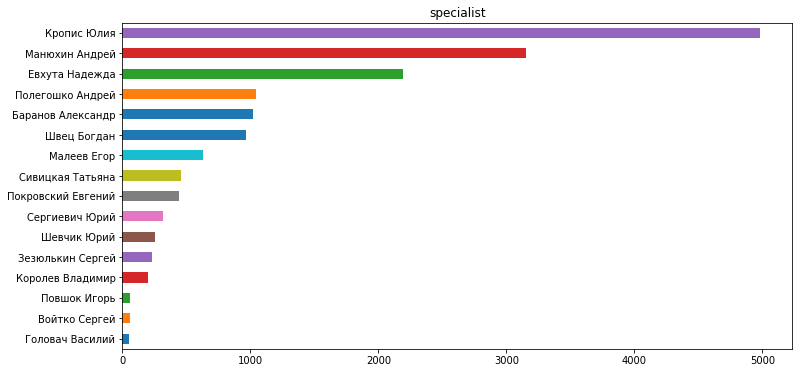

In [157]:
show_distr(df, 'specialist', 0.25)

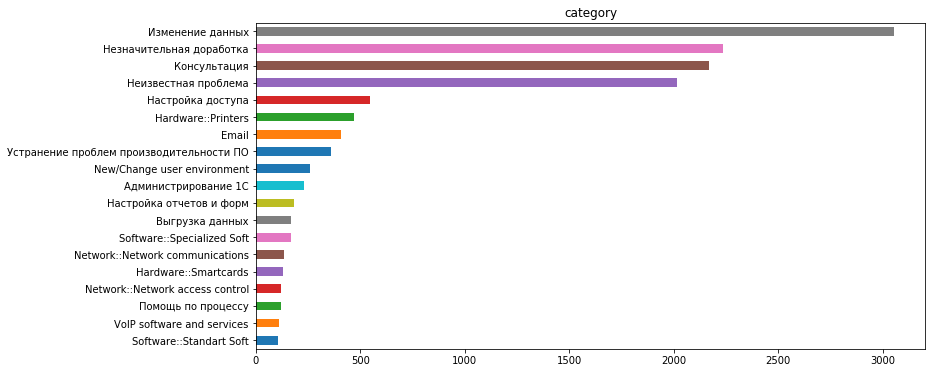

In [158]:
show_distr(df, 'category', 0.75)

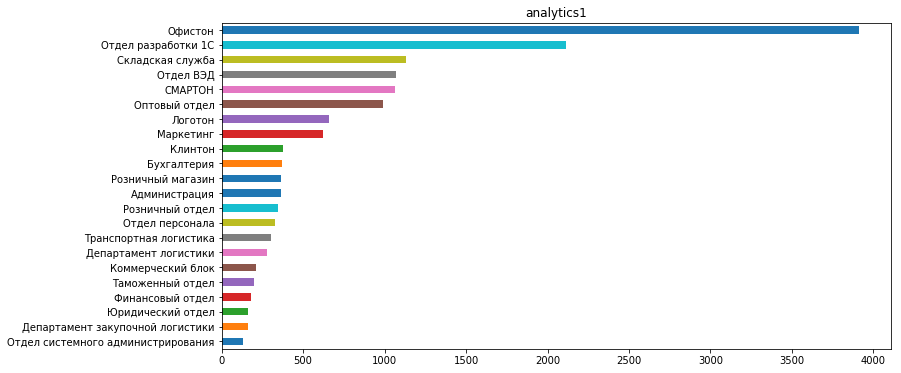

In [159]:
show_distr(df, 'analytics1', 0.50)

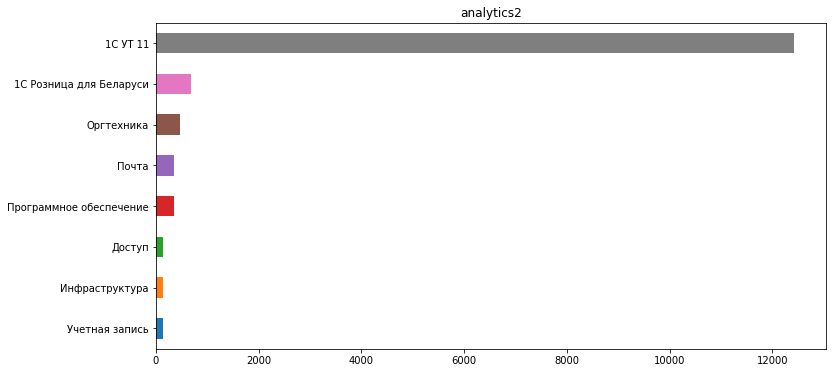

In [160]:
show_distr(df, 'analytics2', 0.85)

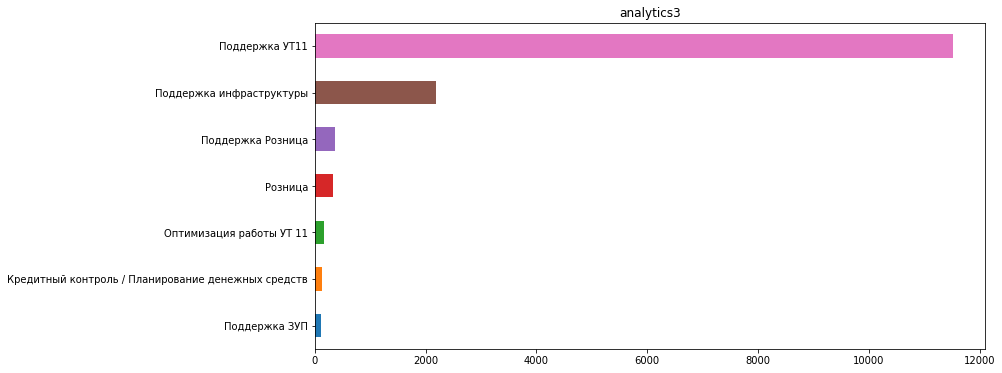

In [161]:
show_distr(df, 'analytics3', 0.85)

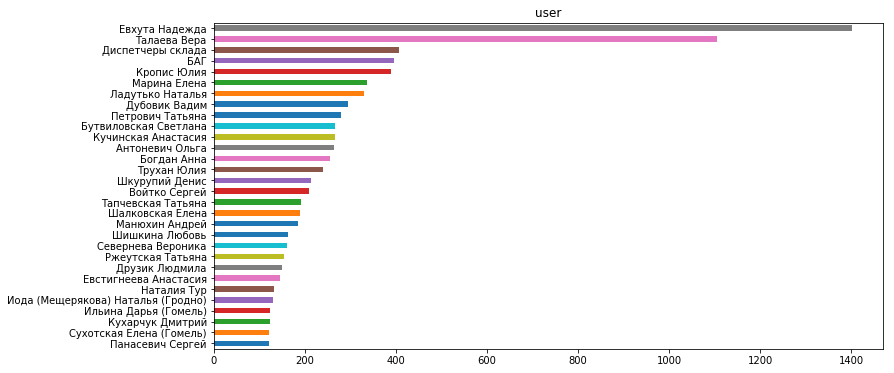

In [162]:
show_distr(df, 'user', 0.90)

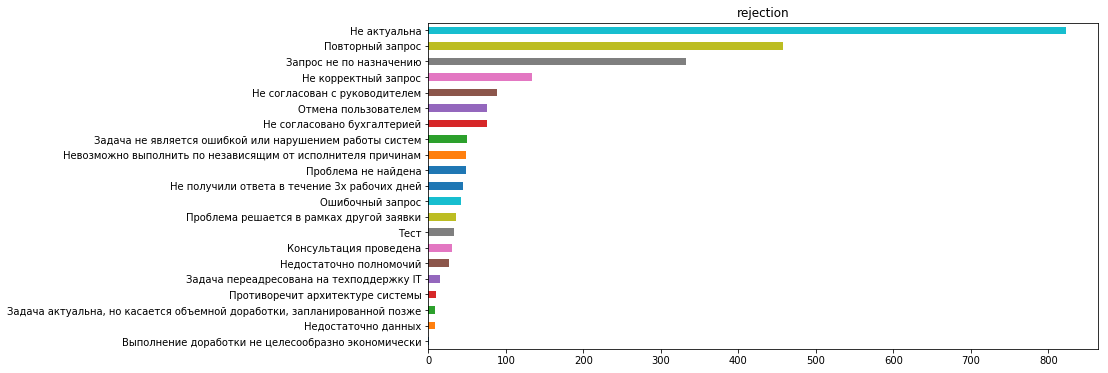

In [163]:
show_distr(df, 'rejection', 0)

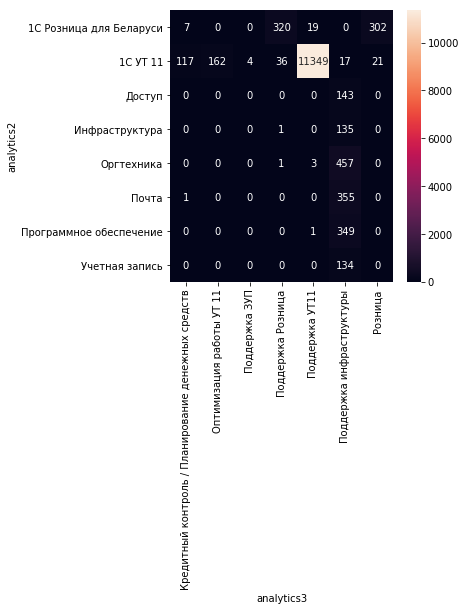

In [164]:
df_analytics = df_origin[['analytics2', 'analytics3']].copy()
analytics2_top = get_top(df_analytics, 'analytics2', 0.85)
analytics3_top = get_top(df_analytics, 'analytics3', 0.85)

df_analytics = df_analytics[df_analytics['analytics2'].isin(analytics2_top) & df_analytics['analytics3'].isin(analytics3_top)]

df_analytics_unst = df_analytics.groupby('analytics2')['analytics3'].value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df_analytics_unst, annot=True, fmt="g")
plt.show()

### Elastic Search Baseline

### Preprocessing

In [165]:
def drop_below(df, name, quantile):
    top_ = get_top(df, name, quantile)
    print('%s top %d' % (name, len(top_)))
    print(df.shape[0], 'before')
    df = df[df[name].isin(top_)]
    print(df.shape[0], 'after')
    return df

In [166]:
# select top specialists
df = drop_below(df, 'specialist', 0.25)
df = drop_below(df, 'analytics1', 0.50)
df = drop_below(df, 'analytics2', 0.85)
df = drop_below(df, 'analytics3', 0.85)
df = drop_below(df, 'category', 0.75)

specialist top 16
16084 before
16056 after
analytics1 top 22
16056 before
15322 after
analytics2 top 8
15322 before
14191 after
analytics3 top 6
14191 before
13485 after
category top 18
13485 before
11323 after


In [167]:
def replace_by_re(s, pattern, repl):
    return re.sub(pattern, repl, s)

df['title'] = df['title'].apply(replace_by_re, args=('1[CСcс]', "Одинэс"))
df['title'] = df['title'].apply(replace_by_re, args=('FW:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('RE:\s+', ""))
# df['title'] = df['title'].apply(replace_by_re, args=('(\d{2}[\.\\\/]){2}(\d{2})+', "дата"))
df['title'] = df['title'].apply(replace_by_re, args=("[\:\#\№%\!\d\-\'\.]", ""))
# df['title'] = df['title'].apply(replace_by_re, args=('\"', ""))

# df = df[df['title']!='']
# df['title'].head()

In [168]:
morph = pymorphy2.MorphAnalyzer()
cnt = Counter()
stop_words = get_stop_words('russian')

def lemmatize(s):
    l = [morph.parse(w)[0].normal_form for w in simple_word_tokenize(s) if not is_punctuation(w)]
    l = [w for w in l if w not in stop_words]
    
    cnt.update(l)
    
    return " ".join(l)

df['title'] = df['title'].apply(lemmatize)

df['title'].loc[:10]

3    проверка работа
Name: title, dtype: object

In [169]:
df_users = pd.get_dummies(df['user'])
df = pd.concat([df, df_users], axis=1)

In [170]:
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    df[x_cols + df_users.columns.tolist()], 
    df[y_cols], 
    df.index, 
    test_size=0.2, 
    random_state=42)

### Transform

In [171]:
labels_test = df.loc[indices_test.values][y_cols]
labels_train = df.loc[indices_train.values][y_cols]

In [172]:
tfidf = TfidfVectorizer(max_features=1000, sublinear_tf=True, norm='l2', ngram_range=(1, 2))

# def get_titles(df):
#     return X_train['title']

# def get_users(df):
#     return X_train['user']

# vec = make_union(*[
#     make_pipeline(FunctionTransformer(get_users, validate=False), LabelBinarizer()),
#     make_pipeline(FunctionTransformer(get_titles, validate=False), TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2)))
# ])

features_train = tfidf.fit_transform(X_train['title'])
features_test = tfidf.transform(X_test['title'])

In [173]:
print(tfidf.get_feature_names()[:100])

['edi', 'elastalert', 'hp', 'info', 'itil', 'megacount', 'missing', 'missing value', 'outlook', 'poligon', 'poligon ref', 're', 're тикета', 'ref', 'request', 'smarton', 'smartonby', 'sr', 'srvr', 'srvr poligon', 'task', 'task request', 'topby', 'value', 'webзаказ', 'август', 'авс', 'автоматически', 'автоматический', 'адрес', 'адрес доставка', 'акт', 'акт сверка', 'актуальный', 'акция', 'алгоритм', 'анализ', 'андрей', 'арт', 'артикул', 'артикул веб', 'ас', 'ас декларант', 'аутлука', 'база', 'база smarton', 'база висеть', 'база невозможно', 'база одинэса', 'база отчёт', 'база работать', 'база сильно', 'база срочно', 'база ут', 'балл', 'балл смартбонус', 'банк', 'банка', 'белкантон', 'блок', 'блокировка', 'бобруйск', 'богдан', 'большой', 'бонус', 'брак', 'браковать', 'браковать товар', 'бсо', 'бсо реализация', 'бу', 'бумага', 'бух', 'бухгалтерия', 'валовый', 'валовый прибыль', 'ввести', 'ввод', 'веб', 'веб заказ', 'вебзаказ', 'ведомость', 'ведомость партия', 'верно', 'верный', 'вертер', 

### Model Search

In [180]:
model = MultinomialNB()

multi_target_nb = MultiOutputClassifier(model, n_jobs=-1)
multi_target_nb.fit(features_train2, labels_train)

labels_pred = multi_target_nb.predict(features_test2)

In [174]:
X_train.columns

Index(['title', 'user', 'Vaskeliene Laura (Вильнюс)', 'Ажойчик Татьяна',
       'Аксиончикова Валерия', 'Ангелина Римша', 'Андреев Вадим (Бобруйск)',
       'Анна Мащер', 'Антон Федоренчик', 'Антоневич Ольга',
       ...
       'Щербицкая Юлия', 'Юлия Пупко', 'Юшкевич Светлана', 'Ямалетдинов Динар',
       'Яна Макейчик', 'Ярига Дмитрий', 'Ярошевич Наталья', 'Ярошевич Татьяна',
       'Яхимович Екатерина', 'Яцевич Роман'],
      dtype='object', length=256)

In [179]:
from scipy.sparse import hstack

features_train2 = hstack(blocks = [features_train, X_train[df_users.columns]])
features_test2 = hstack(blocks = [features_test, X_test[df_users.columns]])

In [177]:
features_train2.shape

<9058x1254 sparse matrix of type '<class 'numpy.float64'>'
	with 41159 stored elements in COOrdinate format>

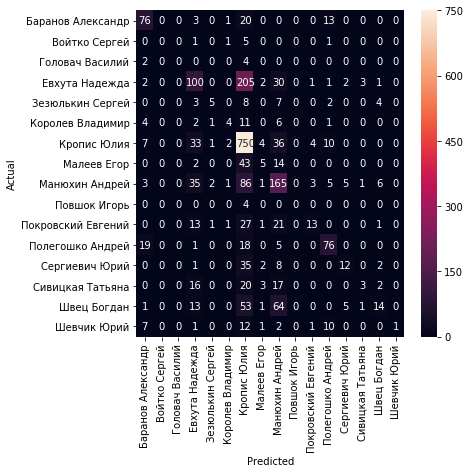

In [181]:
conf_mat = metrics.confusion_matrix(labels_test['specialist'], labels_pred[:, 0], labels=multi_target_nb.estimators_[0].classes_)
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(conf_mat, 
            annot=True, 
            fmt='g',
            xticklabels=multi_target_nb.estimators_[0].classes_,
            yticklabels=multi_target_nb.estimators_[0].classes_
           )

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# plt.savefig('heatmap.png')

In [182]:
print(metrics.classification_report(labels_test['specialist'], labels_pred[:, 0], target_names=multi_target_nb.estimators_[0].classes_))

                    precision    recall  f1-score   support

 Баранов Александр       0.63      0.67      0.65       113
     Войтко Сергей       0.00      0.00      0.00         8
   Головач Василий       0.00      0.00      0.00         6
    Евхута Надежда       0.45      0.29      0.35       347
  Зезюлькин Сергей       0.50      0.17      0.26        29
  Королев Владимир       0.40      0.14      0.21        29
       Кропис Юлия       0.58      0.89      0.70       847
       Малеев Егор       0.25      0.08      0.12        64
    Манюхин Андрей       0.44      0.53      0.48       313
      Повшок Игорь       0.00      0.00      0.00         4
Покровский Евгений       0.59      0.17      0.26        78
  Полегошко Андрей       0.64      0.64      0.64       119
    Сергиевич Юрий       0.50      0.20      0.29        60
  Сивицкая Татьяна       0.38      0.05      0.09        61
       Швец Богдан       0.47      0.09      0.15       152
       Шевчик Юрий       1.00      0.03

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Retrain on full data

In [159]:
features = tfidf.fit_transform(df['title']).toarray()
labels = df[['specialist', 'category', 'analytics1', 'analytics2', 'analytics3']]

model = MultinomialNB()
multi_target_nb = MultiOutputClassifier(model, n_jobs=-1)
multi_target_nb.fit(features, labels)

MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
           n_jobs=-1)

In [160]:
features_1 = tfidf.transform(['зуп эсчф'])

pred_1 = multi_target_nb.predict(features_1[0].reshape(1, -1))
pred_prob_1 = multi_target_nb.predict_proba(features_1[0].reshape(1, -1))

display(pred_1)
display(pred_prob_1)

array([['Сивицкая Татьяна', 'Незначительная доработка',
        'Отдел разработки 1С', '1С УТ 11', 'Поддержка УТ11']],
      dtype='<U40')

[array([[0.03612593, 0.0055984 , 0.0024103 , 0.09619506, 0.0144478 ,
         0.01629441, 0.11958144, 0.02621737, 0.0982409 , 0.0013921 ,
         0.03202082, 0.03733061, 0.02259283, 0.44106047, 0.03815667,
         0.01233491]]),
 array([[0.02588267, 0.02928741, 0.00921725, 0.02488842, 0.01029412,
         0.0089607 , 0.03340872, 0.01678484, 0.1613067 , 0.130088  ,
         0.00669967, 0.03009673, 0.01969158, 0.34054381, 0.11147097,
         0.00746608, 0.0088451 , 0.02506722]]),
 array([[0.0127085 , 0.07006948, 0.00937043, 0.01521987, 0.01919695,
         0.01107391, 0.02458909, 0.02414423, 0.03149237, 0.03390975,
         0.02970059, 0.46995127, 0.00721146, 0.08868573, 0.01857519,
         0.01780867, 0.035425  , 0.03456747, 0.01142421, 0.0166052 ,
         0.00823255, 0.0100381 ]]),
 array([[0.02612336, 0.89021276, 0.01029206, 0.0233347 , 0.01972675,
         0.01341061, 0.00729382, 0.00960594]]),
 array([[0.00701993, 0.01893626, 0.90477223, 0.05160256, 0.01766901]])]

In [161]:
for i in range(len(multi_target_nb.estimators_)):
    indmax = np.argmax(pred_prob_1[i])
    print(multi_target_nb.estimators_[i].classes_[indmax], np.round(pred_prob_1[i][0][indmax], 2))

Сивицкая Татьяна 0.44
Незначительная доработка 0.34
Отдел разработки 1С 0.47
1С УТ 11 0.89
Поддержка УТ11 0.9


In [162]:
# specialist_id messed up

df_ngrams = pd.DataFrame(columns=['specialist', 'unigrams', 'bigrams'])

N = 2
for specialist_id, specialist in enumerate(multi_target_nb.estimators_[0].classes_):
    indices = np.argsort(multi_target_nb.estimators_[0].coef_[specialist_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]

    df_ngrams = df_ngrams.append({
        'specialist':specialist,
        'unigrams':', '.join(unigrams),
        'bigrams':', '.join(bigrams)
    }, ignore_index=True)

df_ngrams

,specialist,unigrams,bigrams
0,Баранов Александр,"переадресация, картридж","переадресация почта, замена картридж"
1,Войтко Сергей,"сотрудник, новый","новый сотрудник, доступ 1с"
2,Головач Василий,"сайт, белкантон","сайт белкантон, товар сайт"
3,Евхута Надежда,"подарок, база","орг вопрос, розница орг"
4,Зезюлькин Сергей,"1с, база","missing value, база 1с"
5,Королев Владимир,"доступ, новый","учётный запись, новый сотрудник"
6,Кропис Юлия,"база, реализация","висеть база, зона доставка"
7,Малеев Егор,"себестоимость, гтд","гтд москва, гтд документ"
8,Манюхин Андрей,"заказ, отчёт","печатный форма, заказ клиент"
9,Повшок Игорь,"сайт, отображаться","отображаться сайт, почтовый ящик"


### Dump and Load check

In [163]:
joblib.dump(multi_target_nb, '../static/itil-multitarget.pkl')
joblib.dump(multi_target_nb.estimators_[0], '../static/itil-multinb.pkl')
joblib.dump(tfidf, '../static/itil-tfidf.pkl')

['../static/itil-tfidf.pkl']

In [57]:
clf = joblib.load('../static/itil-multitarget.pkl')
transformer = joblib.load('../static/itil-tfidf.pkl')
transformer._validate_vocabulary()
features = transformer.transform(['зуп эсчф'])
prediction = clf.predict_proba(features.reshape(1, -1))
prediction

# doc2vec

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess

In [ ]:
def tag_docs(docs, col, label): 
    tagged = docs.apply(lambda r: TaggedDocument(words=simple_preprocess(r[col]), tags=[r[label]]),  axis=1) 
    return tagged

def train_doc2vec_model(tagged_docs): 
    sents = tagged_docs.values
    doc2vec_model = Doc2Vec(sents, epochs=20, dm=1) #size=size, window=window, 
    return doc2vec_model

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values 
    targets, regressors =  zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
train_tagged = tag_docs(train_data, 'title', 'specialist')
test_tagged = tag_docs(test_data, 'title', 'specialist')
model = train_doc2vec_model(train_tagged)

In [ ]:
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))